### Import module

In [1]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, Conv2D, SimpleRNN, LSTM, GRU, Reshape, RepeatVector, MaxPooling2D, Dropout, Bidirectional, Attention, BatchNormalization, Conv2DTranspose, TimeDistributed, GlobalAveragePooling1D, Conv1DTranspose
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

import imblearn

from IPython.display import SVG

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14176978042427907959,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3040504820344242984
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7068565893781779826
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7586198148299747671
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [2]:
num_classes = 7                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10                          # 5초 단위 window: 50, 10초 단위 window: 90, 15초 단위 window: 128
window_size = 50
overlap_ratio = 0.5
bi_class = 0                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=2
mode = 0                                 # Split data {0: Didn't split, 1: US only, 2: Korea only, 3: train with US and test with Korea 4: train with Korea and test with US}

### Load Data

In [3]:
data_fname = '../Data/Preprocessed(new)/preprocessed_data(New collar_2).csv'

### Preprocess Data

In [4]:
data = pd.read_csv(data_fname)
data = data.fillna(0)

In [5]:
iaq = data['iaq']
iaq_cat = []

for num in iaq:
    if num < 50 and num >=0:
        iaq_cat.append('Good')
    elif num >= 50 and num < 100:
        iaq_cat.append('Average')
    elif num >= 100 and num < 150:
        iaq_cat.append('Little bad')
    elif num >= 150 and num < 200:
        iaq_cat.append('Bad')
    elif num >= 200 and num < 300:
        iaq_cat.append('Worse')
    elif num >= 300 and num <= 500:
        iaq_cat.append('Very bad')
    else:
        print(num)
data['iaq_cat'] = iaq_cat

In [6]:
data = pd.concat([data,pd.get_dummies(data['sound category'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orientation_cat'])],axis=1)         # Onehot encode orientation category
data = pd.concat([data,pd.get_dummies(data['iaq_cat'])],axis=1)         # Onehot encode iaq category

In [7]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [8]:
# Normalize Data

scaler = StandardScaler()

# data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)
data['gasResistance'] = scaler.fit_transform(data['gasResistance'].reshape(-1,1)).reshape(-1)
data['staticIaq'] = scaler.fit_transform(data['staticIaq'].reshape(-1,1)).reshape(-1)
data['co2Equivalent'] = scaler.fit_transform(data['co2Equivalent'].reshape(-1,1)).reshape(-1)
data['breathVocEquivalent'] = scaler.fit_transform(data['breathVocEquivalent'].reshape(-1,1)).reshape(-1)
data['audioLevel'] = scaler.fit_transform(data['audioLevel'].reshape(-1,1)).reshape(-1)
data['rawTemp'] = scaler.fit_transform(data['rawTemp'].reshape(-1,1)).reshape(-1)
data['rawHumidity'] = scaler.fit_transform(data['rawHumidity'].reshape(-1,1)).reshape(-1)
data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)

In [9]:
# Split US and Korea
us_rowIDs = []
korea_rowIDs = []

if mode != 0:
    for rowid in rowID_list:
    #     print(rowid, rowid[0])
        if rowid[0] == '1':
            korea_rowIDs.append(rowid)
        else:
            us_rowIDs.append(rowid)

In [10]:
# feature_col_name = ['accX', 'accY', 'accZ', 'chord', 'orientation', 'ir', 'full', 'iaq', 'iaqAccuracy', 'rawTemp',
#                     'pressure', 'rawHumidity', 'gasResistance', 'compGasAccuracy', 'gasPercentageAccuracy', 'temperature', 
#                     'humidity', 'staticIaq', 'statIaqAccuracy', 'co2Equivalent', 'co2Accuracy', 'breathVocEquivalent', 
#                     'breathVocAccuracy', 'audioLevel', 'Loud', 'Moderate', 'Quiet']
feature_col_name = ['accX', 'accY', 'accZ', 'chord', 'full', 'iaq', 'rawTemp',
                    'pressure', 'rawHumidity', 'gasResistance', 'staticIaq', 'co2Equivalent', 'breathVocEquivalent', 
                    'audioLevel', 'Loud', 'Moderate', 'Quiet', 'Landscape Left Back', 'Landscape Left Front', 'Landscape Right Back',
                    'Landscape Right Front', 'Portrait Down Back', 'Portrait Down Front', 'Portrait Up Back', 
                    'Portrait Up Front', 'Average', 'Bad', 'Good', 'Little bad', 'Very bad', 'Worse']
target_col_name = ['Modality_cat']

In [11]:
feature_num = len(feature_col_name)

In [12]:
X = []
us_X = []
korea_X = []

Y = []
us_Y = []
korea_Y = []


if mode != 0:
    for rowID in us_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        us_X.append(feature)
        us_Y.append(target)
    
    for rowID in korea_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        korea_X.append(feature)
        korea_Y.append(target)

else:
    for rowID in rowID_list:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        X.append(feature)
        Y.append(target)

In [13]:
if bi_class != 0:
    #Transit multi classification to binary classification
    if mode != 0:
        for idx in range(len(us_Y)):
            if us_Y[idx] == bi_class-1:
                us_Y[idx]=1
            else:
                us_Y[idx]=0
                
        for idx in range(len(korea_Y)):
            if korea_Y[idx] == bi_class-1:
                korea_Y[idx]=1
            else:
                korea_Y[idx]=0
    else:
        for idx in range(len(Y)):
            if Y[idx] == bi_class-1:
                Y[idx]=1
            else:
                Y[idx]=0

In [14]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [15]:
if mode != 0:
    us_X = X_preprocess(us_X, window_size, overlap_ratio)        ### preprocess with input shape
    korea_X = X_preprocess(korea_X, window_size, overlap_ratio)
    if bi_class == 0:
        ### onehot encode Y
        us_Y = np.eye(num_classes)[us_Y]
        korea_Y = np.eye(num_classes)[korea_Y]
    else: 
        us_Y = np.eye(2)[us_Y]
        korea_Y = np.eye(2)[korea_Y]

else:    
    X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
    if bi_class == 0:
        ### onehot encode Y
        Y = np.eye(num_classes)[Y]
    else: Y = np.eye(2)[Y]

In [16]:
# Subsample X Data size

def subsample(X, min_us_len, min_korea_len):
    sampled_X = []
    addon = 0
    
    if min_korea_len > min_us_len:
        if np.array(X).shape[1] == min_us_len:
            return X
        else:
            interval = min_korea_len / min_us_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_us_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

                sampled_X.append(temp_X)
            
    else:
        if np.array(X).shape[1] == min_korea_len:
            return X
        else:
            interval = min_us_len / min_korea_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_korea_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

            sampled_X.append(temp_X)
                    
    return sampled_X

In [17]:
# Fit to minimum length

min_len = 99999999
min_us_len = 99999999
min_korea_len = 99999999
min_X = []
min_us_X = []
min_korea_X = []

if mode == 0:
#     print('Start mode 0\n')
    for x in X:
        if len(x) < min_len:
            min_len = len(x)
#     print(min_len)

    for x in X:
        min_X.append(x[:min_len])

else:
    for x in us_X:
        if len(x) < min_us_len:
            min_us_len = len(x)
            
    for x in korea_X:
        if len(x) < min_korea_len:
            min_korea_len = len(x)
            
    if mode == 1:
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    elif mode == 2:
        min_korea_len = 60
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    else:
        if min_korea_len < min_us_len:
            min_len = min_korea_len
        else: min_len = min_us_len

        for x in us_X:
            min_us_X.append(x[:min_len])

        for x in korea_X:
            min_korea_X.append(x[:min_len])

In [18]:
# Drop duplicate

if bi_class != 0:
    
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        for i in range(len(Y)):
            if Y[i][1] == 1:
                target_list.append(i)

        for i in target_list:
            for j in range(len(min_X)):
                if j in target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                        if j not in del_list:
                            del_list.append(j)
        X = []
        Target = []

        for i in range(len(Y)):
            if i not in del_list:
                X.append(min_X[i])
                Target.append(Y[i])
                
    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)
                            
        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)
        
        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])
                
        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

else:
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        X = min_X
        Target = Y

    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)

        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)

        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])

        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

In [19]:
if mode == 0:
#     X = subsample(X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)
    
elif mode == 1:
    us_X = subsample(us_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(us_X, us_Target, test_size=0.2)

elif mode == 2:
    korea_X = subsample(korea_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(korea_X, korea_Target, test_size=0.2)

elif mode == 3:
    X_train = subsample(us_X, min_us_len, min_korea_len)
    X_test = subsample(korea_X, min_us_len, min_korea_len)
    Y_train = us_Target 
    Y_test = korea_Target

else:
    X_train = subsample(korea_X, min_us_len, min_korea_len)
    X_test = subsample(us_X, min_us_len, min_korea_len)
    Y_train = korea_Target
    Y_test = us_Target 

-----------------------------------------
### End Setup, separate model sections
-----------------------------------------

### Generative Replay #3 - Variational Autoencoder
- https://blog.keras.io/building-autoencoders-in-keras.html (scroll down to VAE section near end)
- https://keras.io/examples/generative/vae/
- https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/
- https://github.com/analytique-bourassa/VAE-Classifier

In [20]:
### Data Setup ###

#Rebalance the data
if bi_class == 0:
    sm = imblearn.over_sampling.SMOTE()
    X_shape = np.array(X_train).shape
    Y_shape = np.array(Y_train).shape
    new_X_train = np.array(X_train).reshape(X_shape[0], X_shape[1]*X_shape[2]*X_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], X_shape[1], X_shape[2], X_shape[3]])
    X_train = np.array(X_train).transpose([0,1,2,3])
    Y_train = Y_train.reshape(temp[0], Y_shape[1])

else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    X_train = np.array(X_train).transpose([0,1,2,3])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
# np.array(X_train).transpose([0,1,2,3]).shape

In [22]:
# np.array(X_train).transpose([0,3,2,1]).shape

In [23]:
# This is the size of our encoded representations
encoding_dim = num_classes  # Same as original model above, final dense layer should be 
input_shape = np.array(X_train[0]).shape
print(input_shape)

# This is our input data
feature_input = keras.Input(shape=input_shape)
feat_shape=feature_input.shape
print(feat_shape)

#Setup latent dims
original_dim = feature_num                     #feature count
intermediate_dim = 128                 #hidden units
latent_dim = feature_num                        #latent count

(276, 50, 31)
(None, 276, 50, 31)


In [24]:
rnn_unit = 200

In [25]:
# Encoder
x = Input(shape=input_shape, name="encoder_input")

shape_before_reshape = K.int_shape(x)[1:]
rnn_input = Reshape((shape_before_reshape[0], -1), name='encoder_reshape1')(x)
rnn_layer = GRU(units=rnn_unit, return_sequences=True, name='encoder_rnn1')(rnn_input)
# rnn_layer = LSTM(units=rnn_unit, return_sequences=True, name='encoder_rnn2')(rnn_layer)
# rnn_layer = TimeDistributed(Dense(rnn_unit), name='encoder_TD1')(rnn_layer)
# rnn_layer= BatchNormalization(name='encoder_norm_3')(rnn_layer)
# rnn_layer = Bidirectional(GRU(units=rnn_unit, name='encoder_rnn2'))(rnn_layer)
rnn_layer= BatchNormalization(name='encoder_norm_4')(rnn_layer)

encoder_conv_layer1 = Conv1D(filters=64, kernel_size=1, padding="same", strides=1, name="encoder_conv_1")(rnn_layer)
# encoder_conv_layer2 = Conv1D(filters=128, kernel_size=1, padding="same", strides=1, name="encoder_conv_2")(encoder_conv_layer1)

encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_activ_1")(encoder_norm_layer1)
encoder_gap_layer1 = GlobalAveragePooling1D()(encoder_activ_layer1)


output = Dense(units=latent_dim, activation='sigmoid', name='encoder_fc1')(encoder_gap_layer1)

shape_before_gap = K.int_shape(encoder_activ_layer1)[1:]
# encoder_flatten = Flatten()(rnn_output)

encoder_mu = Dense(units=latent_dim, name="encoder_mu")(output)
encoder_log_variance = Dense(units=latent_dim, name="encoder_log_variance")(output)

encoder_mu_log_variance_model = Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + K.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 276, 50, 31) 0                                            
__________________________________________________________________________________________________
encoder_reshape1 (Reshape)      (None, 276, 1550)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_rnn1 (GRU)              (None, 276, 200)     1051200     encoder_reshape1[0][0]           
__________________________________________________________________________________________________
encoder_norm_4 (BatchNormalizat (None, 276, 200)     800         encoder_rnn1[0][0]               
______________________________________________________________________________________

In [26]:
shape_before_gap

(276, 64)

In [27]:
shape_before_reshape[2]

31

In [28]:
shape_before_reshape[1]*shape_before_reshape[2]

1550

In [29]:
# Decoder

decoder_input = Input(shape=(latent_dim), name="decoder_input")
decoder_dense_layer1 = Dense(units=np.prod(shape_before_gap), name="decoder_dense_1")(decoder_input)
# cnn_input = RepeatVector(shape_before_reshape[0])(decoder_dense_layer1)
decoder_reshape = Reshape(target_shape=shape_before_gap)(decoder_dense_layer1)

rnn_layer = GRU(units=shape_before_reshape[1], return_sequences=True, name='decoder_rnn1')(decoder_reshape)
cnn_input = tf.expand_dims(rnn_layer, -1)
decoder_conv_tran_layer1 = Conv2DTranspose(filters=31, kernel_size=1, padding="same", strides=1, name="decoder_conv_tran_1")(cnn_input)
# decoder_conv_tran_layer2 = Conv2DTranspose(filters=shape_before_reshape[2], kernel_size=1, padding="same", strides=1, name="decoder_conv_tran_2")(decoder_conv_tran_layer1)
decoder_norm_layer1 = BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_conv_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_norm_layer1)

# rnn_layer = BatchNormalization(name="decoder_norm_2")(rnn_layer)
# rnn_layer = RepeatVector(shape_before_reshape[1])(rnn_layer)
# decoder_output = Reshape(shape_before_reshape, name='decoder_reshape1')(rnn_layer)



decoder = Model(decoder_input, decoder_conv_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 31)]              0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 17664)             565248    
_________________________________________________________________
reshape (Reshape)            (None, 276, 64)           0         
_________________________________________________________________
decoder_rnn1 (GRU)           (None, 276, 50)           17400     
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 276, 50, 1)]      0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 276, 50, 31)       62        
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 276, 50, 31)     

In [30]:
vae_input = Input(shape=input_shape, name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 276, 50, 31)]     0         
_________________________________________________________________
encoder_model (Functional)   (None, 31)                1069119   
_________________________________________________________________
decoder_model (Functional)   (None, 276, 50, 31)       582834    
Total params: 1,651,953
Trainable params: 1,651,363
Non-trainable params: 590
_________________________________________________________________


In [31]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1,2,3])
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1,2,3])
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer=Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [32]:
### Train the model###

#Fit it to some training data
hist = vae.fit(np.array(X_train).transpose([0,1,2,3]), np.array(X_train).transpose([0,1,2,3]),epochs=500, batch_size=16,
              verbose=1, use_multiprocessing=True)

Epoch 1/500
43/43 [==============================] - 4s 83ms/step - loss: 52431405056.0000
Epoch 2/500
43/43 [==============================] - 3s 80ms/step - loss: 52431413248.0000
Epoch 3/500
43/43 [==============================] - 4s 82ms/step - loss: 52431392768.0000
Epoch 4/500
43/43 [==============================] - 3s 80ms/step - loss: 52431392768.0000
Epoch 5/500
43/43 [==============================] - 3s 80ms/step - loss: 52431392768.0000
Epoch 6/500
43/43 [==============================] - 3s 80ms/step - loss: 52431376384.0000
Epoch 7/500
43/43 [==============================] - 3s 79ms/step - loss: 52431392768.0000
Epoch 8/500
43/43 [==============================] - 3s 79ms/step - loss: 52431388672.0000: 0s - loss: 56957485056.000 - ETA: 0s - loss: 55554023424.0
Epoch 9/500
43/43 [==============================] - 3s 79ms/step - loss: 52431376384.0000
Epoch 10/500
43/43 [==============================] - 3s 79ms/step - loss: 52431380480.0000
Epoch 11/500
43/43 [=========

43/43 [==============================] - 3s 79ms/step - loss: 52431351808.0000
Epoch 89/500
43/43 [==============================] - 3s 80ms/step - loss: 52431376384.00001s -
Epoch 90/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 91/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 92/500
43/43 [==============================] - 3s 79ms/step - loss: 52431364096.0000
Epoch 93/500
43/43 [==============================] - 3s 80ms/step - loss: 52431368192.0000
Epoch 94/500
43/43 [==============================] - 3s 79ms/step - loss: 52431364096.0000
Epoch 95/500
43/43 [==============================] - 3s 80ms/step - loss: 52431376384.0000
Epoch 96/500
43/43 [==============================] - 3s 80ms/step - loss: 52431368192.0000
Epoch 97/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 98/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.00

43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000: 0s - loss: 10
Epoch 175/500
43/43 [==============================] - 3s 80ms/step - loss: 52431355904.0000
Epoch 176/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 177/500
43/43 [==============================] - 3s 81ms/step - loss: 52431355904.0000
Epoch 178/500
43/43 [==============================] - 3s 80ms/step - loss: 52431355904.0000
Epoch 179/500
43/43 [==============================] - 3s 80ms/step - loss: 52431368192.0000
Epoch 180/500
43/43 [==============================] - 3s 81ms/step - loss: 52431351808.0000
Epoch 181/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 182/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 183/500
43/43 [==============================] - 3s 80ms/step - loss: 52431376384.0000
Epoch 184/500
43/43 [==============================] - 3s 80ms/step -

43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 262/500
43/43 [==============================] - 3s 79ms/step - loss: 52431376384.0000
Epoch 263/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 264/500
43/43 [==============================] - 3s 79ms/step - loss: 52431364096.0000
Epoch 265/500
43/43 [==============================] - 3s 80ms/step - loss: 52431368192.0000
Epoch 266/500
43/43 [==============================] - 3s 78ms/step - loss: 52431364096.0000
Epoch 267/500
43/43 [==============================] - 3s 78ms/step - loss: 52431364096.0000
Epoch 268/500
43/43 [==============================] - 3s 79ms/step - loss: 52431355904.0000: 1s - 
Epoch 269/500
43/43 [==============================] - 3s 78ms/step - loss: 52431368192.0000
Epoch 270/500
43/43 [==============================] - 3s 79ms/step - loss: 52431351808.0000
Epoch 271/500
43/43 [==============================] - 3s 79ms/step - loss: 5

43/43 [==============================] - 3s 78ms/step - loss: 52431368192.0000
Epoch 349/500
43/43 [==============================] - 3s 78ms/step - loss: 52431380480.0000
Epoch 350/500
43/43 [==============================] - 3s 77ms/step - loss: 52431368192.0000
Epoch 351/500
43/43 [==============================] - 3s 78ms/step - loss: 52431368192.0000
Epoch 352/500
43/43 [==============================] - 3s 78ms/step - loss: 52431376384.0000
Epoch 353/500
43/43 [==============================] - 3s 78ms/step - loss: 52431380480.0000
Epoch 354/500
43/43 [==============================] - 3s 79ms/step - loss: 52431376384.0000
Epoch 355/500
43/43 [==============================] - 3s 78ms/step - loss: 52431380480.0000
Epoch 356/500
43/43 [==============================] - 3s 78ms/step - loss: 52431355904.0000
Epoch 357/500
43/43 [==============================] - 3s 78ms/step - loss: 52431368192.0000
Epoch 358/500
43/43 [==============================] - 3s 78ms/step - loss: 52431368

43/43 [==============================] - 3s 78ms/step - loss: 52431355904.0000
Epoch 436/500
43/43 [==============================] - 3s 78ms/step - loss: 52431343616.0000
Epoch 437/500
43/43 [==============================] - 3s 79ms/step - loss: 52431343616.0000
Epoch 438/500
43/43 [==============================] - 3s 79ms/step - loss: 52431380480.0000
Epoch 439/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 440/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 441/500
43/43 [==============================] - 3s 79ms/step - loss: 52431380480.0000
Epoch 442/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 443/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368192.0000
Epoch 444/500
43/43 [==============================] - 3s 80ms/step - loss: 52431364096.0000
Epoch 445/500
43/43 [==============================] - 3s 79ms/step - loss: 52431368

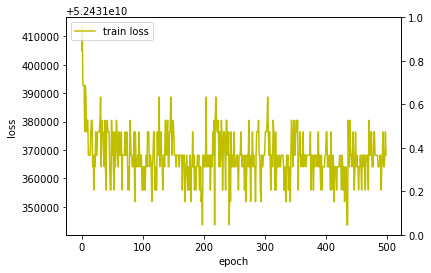

In [33]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [34]:
### Test the model###

vae.evaluate(np.array(X_test).transpose([0,1,2,3]), np.array(X_test).transpose([0,1,2,3]), verbose=1)

3/3 [==============================] - 0s 41ms/step - loss: 8681083904.0000


8681083904.0

### Classification

In [48]:
def fc(enco, bi_class, num_classes):

    den = Dense(16, activation='sigmoid')(enco)
#     den = BatchNormalization()(den)
#     den = tf.keras.layers.LeakyReLU()(den)
    if bi_class == 0:
        den = Dense(num_classes, activation='softmax')(den)
    else:
        den = Dense(2, activation='softmax')(den)
#     den = BatchNormalization()(den)
#     den = tf.keras.layers.LeakyReLU()(den)
#     den = Dense(7)(den)
#     den = BatchNormalization()(den)
#     out = tf.keras.activations.softmax(den)
    
    return den

In [49]:
encode = encoder(feature_input)
full_model = Model(feature_input,fc(encode, bi_class, num_classes), name="Classification_model")
full_model.summary()

Model: "Classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 276, 50, 31)]     0         
_________________________________________________________________
encoder_model (Functional)   (None, 31)                1069119   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                512       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 119       
Total params: 1,069,750
Trainable params: 631
Non-trainable params: 1,069,119
_________________________________________________________________


In [50]:
encoder.layers

In [51]:
full_model.layers[1].layers

In [52]:
for l1,l2 in zip(full_model.layers[1].layers[:], encoder.layers[:]):
    l1.set_weights(l2.get_weights())

In [53]:
for layer in full_model.layers[0:2]:
    layer.trainable = False

In [54]:
if bi_class == 0:
    full_model.compile(optimizer=Adam(lr=0.05), loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.AUC(multi_label=True), tfa.metrics.F1Score(num_classes=num_classes)])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=500)
else:
    full_model.compile(optimizer=Adam(lr=0.05), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=1000)

Epoch 1/500
17/17 [==============================] - 2s 108ms/step - loss: 1.9682 - categorical_accuracy: 0.1381 - auc_1: 0.4682 - f1_score: 0.1017 - val_loss: 2.9980 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1713 - val_f1_score: 0.0162
Epoch 2/500
17/17 [==============================] - 1s 58ms/step - loss: 1.8622 - categorical_accuracy: 0.1915 - auc_1: 0.5267 - f1_score: 0.1216 - val_loss: 2.9825 - val_categorical_accuracy: 0.0000e+00 - val_auc_1: 0.1713 - val_f1_score: 0.0000e+00
Epoch 3/500
17/17 [==============================] - 1s 57ms/step - loss: 1.8157 - categorical_accuracy: 0.2376 - auc_1: 0.5581 - f1_score: 0.1506 - val_loss: 3.5672 - val_categorical_accuracy: 0.0000e+00 - val_auc_1: 0.1681 - val_f1_score: 0.0000e+00
Epoch 4/500
17/17 [==============================] - 1s 58ms/step - loss: 1.8082 - categorical_accuracy: 0.1823 - auc_1: 0.5478 - f1_score: 0.1310 - val_loss: 3.1591 - val_categorical_accuracy: 0.0000e+00 - val_auc_1: 0.1735 - val_f1_score: 0.0000e+00

17/17 [==============================] - 1s 57ms/step - loss: 1.7332 - categorical_accuracy: 0.2357 - auc_1: 0.6097 - f1_score: 0.1605 - val_loss: 3.2546 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1848 - val_f1_score: 0.0162
Epoch 35/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7524 - categorical_accuracy: 0.2652 - auc_1: 0.6006 - f1_score: 0.1772 - val_loss: 2.9885 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1810 - val_f1_score: 0.0162
Epoch 36/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7390 - categorical_accuracy: 0.2376 - auc_1: 0.6208 - f1_score: 0.1756 - val_loss: 3.3641 - val_categorical_accuracy: 0.0147 - val_auc_1: 0.1842 - val_f1_score: 0.0110
Epoch 37/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7342 - categorical_accuracy: 0.2486 - auc_1: 0.6282 - f1_score: 0.1625 - val_loss: 3.2795 - val_categorical_accuracy: 0.0147 - val_auc_1: 0.1907 - val_f1_score: 0.0110
Epoch 38/500
17/17 [=============

17/17 [==============================] - 1s 58ms/step - loss: 1.7308 - categorical_accuracy: 0.2468 - auc_1: 0.6227 - f1_score: 0.1710 - val_loss: 3.1935 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1839 - val_f1_score: 0.0162
Epoch 68/500
17/17 [==============================] - 1s 59ms/step - loss: 1.7264 - categorical_accuracy: 0.2597 - auc_1: 0.6167 - f1_score: 0.1778 - val_loss: 3.3943 - val_categorical_accuracy: 0.0074 - val_auc_1: 0.1844 - val_f1_score: 0.0056
Epoch 69/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7430 - categorical_accuracy: 0.2413 - auc_1: 0.6133 - f1_score: 0.1645 - val_loss: 3.1545 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1879 - val_f1_score: 0.0162
Epoch 70/500
17/17 [==============================] - 1s 55ms/step - loss: 1.7485 - categorical_accuracy: 0.2634 - auc_1: 0.6018 - f1_score: 0.1813 - val_loss: 3.4367 - val_categorical_accuracy: 0.0000e+00 - val_auc_1: 0.1856 - val_f1_score: 0.0000e+00
Epoch 71/500
17/17 [=====

17/17 [==============================] - 1s 56ms/step - loss: 1.7263 - categorical_accuracy: 0.2652 - auc_1: 0.6252 - f1_score: 0.1979 - val_loss: 3.2232 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1863 - val_f1_score: 0.0258
Epoch 101/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7149 - categorical_accuracy: 0.2394 - auc_1: 0.6308 - f1_score: 0.2081 - val_loss: 3.2805 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1904 - val_f1_score: 0.0175
Epoch 102/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7170 - categorical_accuracy: 0.2652 - auc_1: 0.6203 - f1_score: 0.2075 - val_loss: 3.2786 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1888 - val_f1_score: 0.0152
Epoch 103/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7109 - categorical_accuracy: 0.2486 - auc_1: 0.6371 - f1_score: 0.1799 - val_loss: 3.1102 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1873 - val_f1_score: 0.0227
Epoch 104/500
17/17 [=========

17/17 [==============================] - 1s 57ms/step - loss: 1.7146 - categorical_accuracy: 0.2726 - auc_1: 0.6249 - f1_score: 0.2009 - val_loss: 3.2129 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1899 - val_f1_score: 0.0227
Epoch 134/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7246 - categorical_accuracy: 0.2486 - auc_1: 0.6178 - f1_score: 0.1999 - val_loss: 3.3478 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1859 - val_f1_score: 0.0227
Epoch 135/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7189 - categorical_accuracy: 0.2670 - auc_1: 0.6129 - f1_score: 0.2083 - val_loss: 3.2924 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1863 - val_f1_score: 0.0175
Epoch 136/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7216 - categorical_accuracy: 0.2597 - auc_1: 0.6211 - f1_score: 0.1887 - val_loss: 3.2112 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1875 - val_f1_score: 0.0227
Epoch 137/500
17/17 [=========

17/17 [==============================] - 1s 55ms/step - loss: 1.7106 - categorical_accuracy: 0.2762 - auc_1: 0.6346 - f1_score: 0.2112 - val_loss: 3.3775 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1865 - val_f1_score: 0.0227
Epoch 167/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7174 - categorical_accuracy: 0.2615 - auc_1: 0.6197 - f1_score: 0.2108 - val_loss: 3.4477 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1853 - val_f1_score: 0.0121
Epoch 168/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7114 - categorical_accuracy: 0.2560 - auc_1: 0.6305 - f1_score: 0.1961 - val_loss: 3.3392 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1838 - val_f1_score: 0.0121
Epoch 169/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7113 - categorical_accuracy: 0.2689 - auc_1: 0.6243 - f1_score: 0.1957 - val_loss: 3.2597 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1890 - val_f1_score: 0.0258
Epoch 170/500
17/17 [=========

17/17 [==============================] - 1s 57ms/step - loss: 1.7068 - categorical_accuracy: 0.2597 - auc_1: 0.6189 - f1_score: 0.2076 - val_loss: 3.3345 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1877 - val_f1_score: 0.0227
Epoch 200/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7124 - categorical_accuracy: 0.2744 - auc_1: 0.6162 - f1_score: 0.2004 - val_loss: 3.3364 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1834 - val_f1_score: 0.0258
Epoch 201/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7137 - categorical_accuracy: 0.2726 - auc_1: 0.6200 - f1_score: 0.2094 - val_loss: 3.2142 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1862 - val_f1_score: 0.0227
Epoch 202/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7133 - categorical_accuracy: 0.2560 - auc_1: 0.6255 - f1_score: 0.1952 - val_loss: 3.2495 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1847 - val_f1_score: 0.0096
Epoch 203/500
17/17 [=========

17/17 [==============================] - 1s 58ms/step - loss: 1.7193 - categorical_accuracy: 0.2744 - auc_1: 0.6232 - f1_score: 0.2058 - val_loss: 3.2333 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1880 - val_f1_score: 0.0258
Epoch 233/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7221 - categorical_accuracy: 0.2689 - auc_1: 0.6105 - f1_score: 0.1953 - val_loss: 3.4263 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1803 - val_f1_score: 0.0206
Epoch 234/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7178 - categorical_accuracy: 0.2634 - auc_1: 0.6100 - f1_score: 0.2022 - val_loss: 3.2707 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1872 - val_f1_score: 0.0258
Epoch 235/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7234 - categorical_accuracy: 0.2486 - auc_1: 0.6122 - f1_score: 0.2015 - val_loss: 3.3864 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1873 - val_f1_score: 0.0175
Epoch 236/500
17/17 [=========

17/17 [==============================] - 1s 58ms/step - loss: 1.7348 - categorical_accuracy: 0.2707 - auc_1: 0.6264 - f1_score: 0.1990 - val_loss: 3.4006 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1891 - val_f1_score: 0.0227
Epoch 266/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7082 - categorical_accuracy: 0.2726 - auc_1: 0.6194 - f1_score: 0.2127 - val_loss: 3.2868 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1870 - val_f1_score: 0.0258
Epoch 267/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7053 - categorical_accuracy: 0.2652 - auc_1: 0.6237 - f1_score: 0.2080 - val_loss: 3.4391 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1763 - val_f1_score: 0.0121
Epoch 268/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7053 - categorical_accuracy: 0.2634 - auc_1: 0.6269 - f1_score: 0.1992 - val_loss: 3.3311 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1881 - val_f1_score: 0.0175
Epoch 269/500
17/17 [=========

Epoch 298/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7287 - categorical_accuracy: 0.2762 - auc_1: 0.6183 - f1_score: 0.2074 - val_loss: 3.3881 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1891 - val_f1_score: 0.0227
Epoch 299/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7167 - categorical_accuracy: 0.2652 - auc_1: 0.6231 - f1_score: 0.2025 - val_loss: 3.3448 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1893 - val_f1_score: 0.0258
Epoch 300/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7222 - categorical_accuracy: 0.2173 - auc_1: 0.6013 - f1_score: 0.1936 - val_loss: 3.2780 - val_categorical_accuracy: 0.0515 - val_auc_1: 0.1925 - val_f1_score: 0.0289
Epoch 301/500
17/17 [==============================] - 1s 55ms/step - loss: 1.7123 - categorical_accuracy: 0.2707 - auc_1: 0.6240 - f1_score: 0.2082 - val_loss: 3.2805 - val_categorical_accuracy: 0.0515 - val_auc_1: 0.1880 - val_f1_score: 0.0289
Epoch 302/500
17

17/17 [==============================] - 1s 57ms/step - loss: 1.7142 - categorical_accuracy: 0.2707 - auc_1: 0.6098 - f1_score: 0.1995 - val_loss: 3.2841 - val_categorical_accuracy: 0.0221 - val_auc_1: 0.1882 - val_f1_score: 0.0121
Epoch 332/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7005 - categorical_accuracy: 0.2670 - auc_1: 0.6360 - f1_score: 0.2087 - val_loss: 3.3773 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1848 - val_f1_score: 0.0258
Epoch 333/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7062 - categorical_accuracy: 0.2744 - auc_1: 0.6335 - f1_score: 0.2160 - val_loss: 3.3478 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1807 - val_f1_score: 0.0258
Epoch 334/500
17/17 [==============================] - 1s 57ms/step - loss: 1.6954 - categorical_accuracy: 0.2744 - auc_1: 0.6348 - f1_score: 0.2147 - val_loss: 3.3567 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1814 - val_f1_score: 0.0258
Epoch 335/500
17/17 [=========

17/17 [==============================] - 1s 57ms/step - loss: 1.7220 - categorical_accuracy: 0.2541 - auc_1: 0.6171 - f1_score: 0.1918 - val_loss: 3.4706 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1873 - val_f1_score: 0.0227
Epoch 365/500
17/17 [==============================] - 1s 58ms/step - loss: 1.6985 - categorical_accuracy: 0.2634 - auc_1: 0.6304 - f1_score: 0.2131 - val_loss: 3.3498 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1830 - val_f1_score: 0.0175
Epoch 366/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7185 - categorical_accuracy: 0.2670 - auc_1: 0.6213 - f1_score: 0.1984 - val_loss: 3.4183 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1783 - val_f1_score: 0.0175
Epoch 367/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7110 - categorical_accuracy: 0.2597 - auc_1: 0.6139 - f1_score: 0.2038 - val_loss: 3.3935 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1831 - val_f1_score: 0.0227
Epoch 368/500
17/17 [=========

17/17 [==============================] - 1s 57ms/step - loss: 1.7029 - categorical_accuracy: 0.2744 - auc_1: 0.6315 - f1_score: 0.2182 - val_loss: 3.3014 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1845 - val_f1_score: 0.0258
Epoch 398/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7028 - categorical_accuracy: 0.2744 - auc_1: 0.6298 - f1_score: 0.2197 - val_loss: 3.3635 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1834 - val_f1_score: 0.0227
Epoch 399/500
17/17 [==============================] - 1s 58ms/step - loss: 1.6918 - categorical_accuracy: 0.2799 - auc_1: 0.6233 - f1_score: 0.2101 - val_loss: 3.4289 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1866 - val_f1_score: 0.0258
Epoch 400/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7011 - categorical_accuracy: 0.2670 - auc_1: 0.6217 - f1_score: 0.2061 - val_loss: 3.3636 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1872 - val_f1_score: 0.0227
Epoch 401/500
17/17 [=========

17/17 [==============================] - 1s 56ms/step - loss: 1.6996 - categorical_accuracy: 0.2486 - auc_1: 0.6325 - f1_score: 0.1951 - val_loss: 3.3353 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1799 - val_f1_score: 0.0227
Epoch 431/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7042 - categorical_accuracy: 0.2762 - auc_1: 0.6282 - f1_score: 0.2136 - val_loss: 3.3255 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1874 - val_f1_score: 0.0227
Epoch 432/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7183 - categorical_accuracy: 0.2505 - auc_1: 0.6268 - f1_score: 0.2017 - val_loss: 3.4605 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1849 - val_f1_score: 0.0227
Epoch 433/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7098 - categorical_accuracy: 0.2818 - auc_1: 0.6208 - f1_score: 0.2224 - val_loss: 3.3521 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1832 - val_f1_score: 0.0227
Epoch 434/500
17/17 [=========

17/17 [==============================] - 1s 59ms/step - loss: 1.6923 - categorical_accuracy: 0.2799 - auc_1: 0.6320 - f1_score: 0.2178 - val_loss: 3.3913 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1886 - val_f1_score: 0.0258
Epoch 464/500
17/17 [==============================] - 1s 57ms/step - loss: 1.6979 - categorical_accuracy: 0.2726 - auc_1: 0.6178 - f1_score: 0.2115 - val_loss: 3.4970 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1774 - val_f1_score: 0.0227
Epoch 465/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7082 - categorical_accuracy: 0.2634 - auc_1: 0.6221 - f1_score: 0.2078 - val_loss: 3.4340 - val_categorical_accuracy: 0.0294 - val_auc_1: 0.1823 - val_f1_score: 0.0175
Epoch 466/500
17/17 [==============================] - ETA: 0s - loss: 1.7029 - categorical_accuracy: 0.2744 - auc_1: 0.6178 - f1_score: 0.205 - 1s 57ms/step - loss: 1.7029 - categorical_accuracy: 0.2744 - auc_1: 0.6178 - f1_score: 0.2058 - val_loss: 3.3878 - val_categorical_

Epoch 496/500
17/17 [==============================] - 1s 58ms/step - loss: 1.7155 - categorical_accuracy: 0.2744 - auc_1: 0.6091 - f1_score: 0.2128 - val_loss: 3.5548 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1847 - val_f1_score: 0.0258
Epoch 497/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7217 - categorical_accuracy: 0.2376 - auc_1: 0.6147 - f1_score: 0.1955 - val_loss: 3.3188 - val_categorical_accuracy: 0.0441 - val_auc_1: 0.1847 - val_f1_score: 0.0258
Epoch 498/500
17/17 [==============================] - 1s 57ms/step - loss: 1.7104 - categorical_accuracy: 0.2670 - auc_1: 0.6177 - f1_score: 0.2009 - val_loss: 3.4288 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1845 - val_f1_score: 0.0227
Epoch 499/500
17/17 [==============================] - 1s 56ms/step - loss: 1.7003 - categorical_accuracy: 0.2505 - auc_1: 0.6316 - f1_score: 0.2014 - val_loss: 3.4165 - val_categorical_accuracy: 0.0368 - val_auc_1: 0.1857 - val_f1_score: 0.0206
Epoch 500/500
17

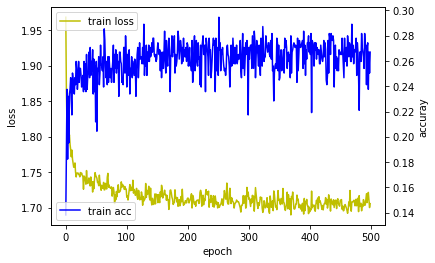

In [55]:
# Display acc, loss
if bi_class == 0:
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')

    acc_ax.plot(hist.history['categorical_accuracy'], 'b', label='train acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
else:
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [56]:
predictions = full_model.predict(np.array(X_test).transpose([0,1,2,3]))

if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Multiclass Test AUC:  0.4868759290226682


In [57]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency

array([14.,  5.,  0.,  7., 46.,  1.,  0.])

In [58]:
print(np.sum(Y_test, axis=0))

[ 3.  8. 23. 21.  9.  4.  5.]


In [59]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

3/3 - 0s - loss: 2.2258 - categorical_accuracy: 0.1370 - auc_1: 0.4812 - f1_score: 0.1243

Accuracy: 0.13698630034923553


In [60]:
# ###Visualize Latent Space###

# x_test_encoded = encoder.predict(np.array(X_test).transpose([0,1,2,3]), batch_size=1)
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test)
# plt.colorbar()
# plt.show()
